<a href="https://colab.research.google.com/github/rg-smith/remote_sensing_course/blob/main/labs/lab6/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6

**In this lab, you will use python (and a module called Google Earth Engine) to view satellite imagery, and calculate ratios and indices. The lab is divided into three parts:**

**Part 1: Imaging minerals in Eritrea**

**Part 2: Imaging freshwater in the Ozarks**

**Part 3: Apply what you've learned to your term project**

The majority of the code here does not need to be modified, only run. The portions of code that do need to be modified will be shown clearly.

Before starting the sections, we will import the modules we need, initialize Google Earth Engine, and define some functions.

The first block of code only needs to be run once, the first time you open your session (if you close out of the session and open again, you will need to run this again). Follow the prompts to initialize earth engine. You will be taken to a link where you need to give permission to link your google account with Google Earth Engine, then copy and paste some text below the code block.

In [ ]:
import ee
import folium
import numpy as np
import branca.colormap as cm

ee.Authenticate()
ee.Initialize()

This block of code also only needs to be run once. It is defining a bunch of functions that you will use in this exercise. It is not important for you to understand the code here for this exercise.

In [13]:
# functions needed for this lab (and some other useful ones that you can use if you're interested)

# to add a layer to our map:
def add_ee_layer(self, ee_object, name):
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):  
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]))
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))

# to convert a google earth engine image to a python array
def to_array(img,aoi):
  band_arrs = img.sampleRectangle(region=aoi)

  band_names=band_arrs.bandNames().getInfo()

  for kk in range(len(band_names)):
    if kk==0:
      dat1=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full=np.zeros((dat1.shape[0],dat1.shape[1],len(band_names)))
      dat_full[:,:,kk]=dat1
    else:
      dat=np.array(band_arrs.get(band_names[kk]).getInfo())
      dat_full[:,:,kk]=dat
  return(dat_full)

# to calculate an index
def getIndex(image,b1,b2):
  return image.normalizedDifference([b1, b2])

# to calculate a ratio
def getRatio(image1,image2):
  ratio=image1.divide(image2)
  return ratio

# to create a color map from a specific image
def getVisparams(image,aoi):
  range = image.reduceRegion(ee.Reducer.percentile([1, 99]),aoi,300)
  vals = range.getInfo()
  min=list(vals.items())[0][1]
  max=list(vals.items())[1][1]
  visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(visParams)

# to get the link to download an earth engine image
def getLink(image,aoi):
  link = image.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi})
  print(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  import ee
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

# load landsat 8 data
def get_l8_image(date1,date2,geometry):
    import ee
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT')
    l8_img = l8.filterDate(date1,date2).filterBounds(geometry).first().clip(geometry)
    return(l8_img)

# load sentinel 2 data
def get_s2_image(date1,date2,geometry):
    import ee
    s2 = ee.ImageCollection('COPERNICUS/S2')
    s2_img = s2.filterDate(date1,date2).filterBounds(geometry).first().clip(geometry)
    return(s2_img)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Part 1: Imaging minerals in Eritria

In this section we will focus on using multi-spectral optical remote sensing data for mineral exploration. Specifically, we will attempt to image hydrothermal alteration zones associated with gold-bearing massive sulfide deposits. The surface expression of these hydrothermal alteration zones is in the form of both clay and iron concentration and associated gossans. For this, we will focus on northern Eritrea which is dominated by N-trending Neoproterozoic layered rocks and granitic intrusions. Eritrea became an independent state in NE Africa in 1994 after 30 years of independent war with Ethiopia. A prior S&T graduate student has been involved in a NASA-funded project to help Eritrea develop its mineral resources. Results of this study are published in “Abdelsalam, M.G., Stern, R.J., and Berhane, W.G., 2000. Mapping Gossans in Arid Regions with Landsat TM and SIR-C/X-SAR Imagery: The Beddaho Alteration Zone in Northern Eritrea, Journal of African Earth Sciences, 30, 903-916”. 

Your task is to perform remote sensing analysis of the region that can help mineral exploration companies to locate possible sites for future development. 

First, we will define the study area and time period and load some Landsat 8 data

In [ ]:
# create a bounding box that defines the study area
geom_ethiopia = addGeometry(38.22, 38.40,17.22,17.48) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2017-01-01'
end = '2017-04-01'

# pull Landsat data over the time period and region previously defined. This pulls the first image found in the date range defined
l8_img_ethiopia = get_l8_image(start,end,geom_ethiopia)

**You need to modify the code below.**

We are looking for Gossans, which have low clay content and high iron-oxide content. There is a clay minerals ratio and an iron oxide ratio that can be used for each of these.

Look up what looks like a good ratio for each of these (use the indices given in Canvas). Then, replace each 'Bn' with a band number that has this format: 'B1','B2', etc. The first 'Bn' will be the numerator, and the second will be the denominator. This image is from Landsat 8, so be sure to use band numbers for Landsat 8. These are given under Canvas (Files > Resources > Landsat8_bands.png

After defining a ratio for clays (high should mean more clay) and iron oxides, make another ratio to highlight gossans. You can do this by dividing the iron oxide ratio by the clay ratio.

In [ ]:
# Replace the bands here with bands that you think make sense to come up with an index for each measurement
clayratio = getRatio(l8_img_ethiopia.select('Bn'),l8_img_ethiopia.select('Bn'))
ior = getRatio(l8_img_ethiopia.select('Bn'),l8_img_ethiopia.select('Bn'))

# divide iron oxide ratio by clay ratio
gossans = getRatio(ior,clayratio)

Now, we will view the map. Scroll to the top so you can check/uncheck layers. Observe areas that are likely to have Gossans. Take a screenshot to include in your lab report, and describe the wavelengths you used for your ratios.

In [ ]:
my_map = folium.Map(location=[17.3, 38.3], zoom_start=12)

# Add the land cover to the map object.
my_map.add_ee_layer(clayratio,'Clay Minerals Ratio')
my_map.add_ee_layer(ior,'Iron Ferrous Minerals Ratio')
my_map.add_ee_layer(gossans,'Gossans')
my_map.add_ee_layer(geom_ethiopia,'bounding box')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Now, we will download the ratios that we created as geotiffs. Once you have downloaded them, load them into ArcMap. Create a shapefile over one area that you think is likely to have Gossans. Take a screenshot and include with your report.

In [ ]:
print('clay minerals ratio raster download:')
getLink(clayratio,geom_ethiopia)
print('iron oxide ratio raster download:')
getLink(ior,geom_ethiopia)
print('gossans ratio raster download:')
getLink(gossans,geom_ethiopia)

clay minerals ratio raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad3a59a9d47db5f2ae26eda03c42cc35-5e952e6d504e4f8efd097f9b93b5d592:getPixels
iron oxide ratio raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50f32448c95aba9c0562d77b549984a5-53ba6637ac5cb892caff2f188e7383d0:getPixels
gossans ratio raster download:
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/702448758118e5cb5f078c3093e753a4-fe36b39d9806f5166bc31b3abe2bfd16:getPixels


# Part 2: Imaging freshwater in the Ozarks

For this section of the lab, we will follow a similar process, but now we will create a normalized index, instead of a ratio, that will highlight freshwater.

First, we will define the study area and time frame like before.

In [ ]:
# create a bounding box that defines the study area. This will cover the Lake of the Ozarks region
geom_ozarks = addGeometry(-92.62,-93.42,38.04,38.40) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = '2017-01-01'
end = '2017-04-01'

# pull landsat image over the study area and dates defined
l8_img_ozarks = get_l8_image(start,end,geom_ozarks)

**You will modify the next block of code**

Define an index that gives a high value for water and a low value for everything else. We don't have any indices we've discussed in class for this, so create your own. Use the spectral reflectance of water, shown below, to do this.

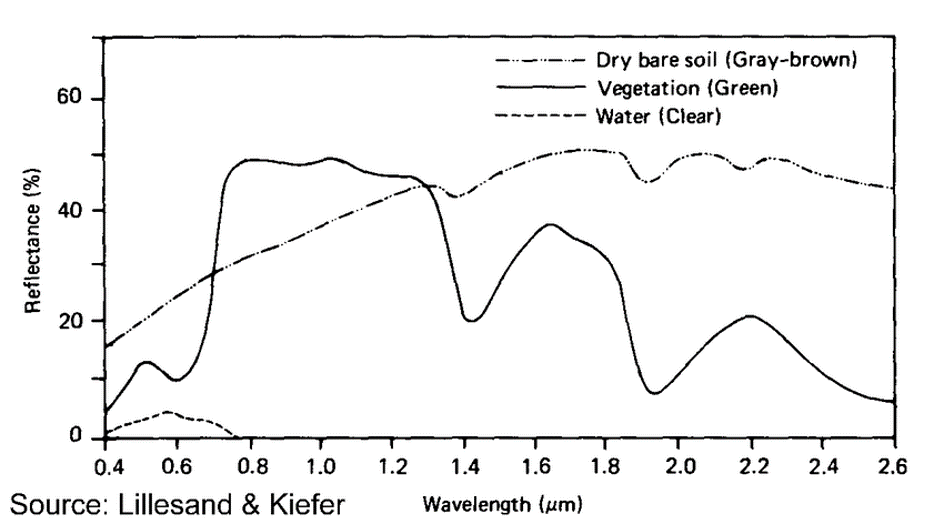

The normalized index has this formula:

(A-B)/(A+B)

In the code block, the first 'Bn' represents A in the equation above, and the second 'Bn' represents B in the equation above.

In [ ]:
waterindex = getIndex(l8_img_ozarks,'Bn','Bn')

Now, you will display the map. Try at least three different indices. Include a screenshot and description of what wavelengths you used for each one in your lab report.

In [ ]:
my_map = folium.Map(location=[38.1, -92.92], zoom_start=11)

# Add the land cover to the map object.
my_map.add_ee_layer(waterindex,'Water Index')
my_map.add_ee_layer(geom_ozarks,'bounding box')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

# Part 3: Apply to your term project

Now, the fun part! Use a previously defined index, or create your own, over the study area that you have decided on for your term project. 

First, replace the coordinates (min lon, max lon, etc.) with coordinates of the minimum and maximum longitude and latitude of your study area. (Hint: don't make it too big, or google earth engine will get bogged down. A range of 1 degree or so is usually fine). Then replace the 'yyyy-mm-dd' for start and end to reflect dates that you are interested in. This is Landsat8, so be sure to pick dates when you know Landsat 8 was in orbit. The algorithm will pick the first image it can find, so the start date is the most important.

In [ ]:
# create a bounding box that defines the study area. This will cover the Lake of the Ozarks region
geom_studyarea = addGeometry(minlon,maxlon,minlat,maxlat) # min long, max long, min lat, max lat

# define dates of interest (inclusive).
start = 'yyyy-mm-dd'
end = 'yyyy-mm-dd'

# pull landsat image over the study area and dates defined
l8_img_studyarea = get_l8_image(start,end,geom_studyarea)

Create your own index (or use one that has been created by someone else). Explain in your lab report what the wavelengths for the index are, and why it will be helpful for your term project.

In [ ]:
yourindex = getIndex(l8_img_studyarea,'Bn','Bn')

View the map. You'll have to replace lat and lon with the coordinates you want the map centered on.

In [ ]:
my_map = folium.Map(location=[lat, lon], zoom_start=11)

# Add the land cover to the map object.
my_map.add_ee_layer(yourindex,'My Index')
my_map.add_ee_layer(geom_studyarea,'bounding box')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

You can download the index if you'd like by running this code:

In [ ]:
print('index raster download:')
getLink(yourindex,geom_studyarea)